## <img src="./fiuba.jpg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico 1
#### Gonzalo Lavigna

***
## Procesos Aleatorios



<div class="alert alert-block alert-info">
<b>1)</b> Analizamos el pulso de referencia dado por la catedra
</div>

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sc
from scipy import signal
import scipy.stats


def simple_fft(yy,fs,N):
    """
    brief:  Genera la DFT, pero utilizando la FFT como algoritmo
    Entradas
    yy: Señal de entrada a convertir en DFT
    ts: Tiempo de sampleo en segundos
    N:  Numero de muestras de la señal
    
    Salidas
    ff: Campo de las frecuencias para poder hacer un grafico
    XX: Espectro de la señal en valor absoluto y solo una mitad.
        Magnitud Normalizada.
    """
    
    delta_f = (fs/2)/(N//2) ;
    
    XX = (2/N)*np.abs(sc.fft(yy));
    XX = XX[0:N//2];
    ff = np.linspace(0,(fs/2)-delta_f,N//2);
     
    return ff,XX

<StemContainer object of 3 artists>

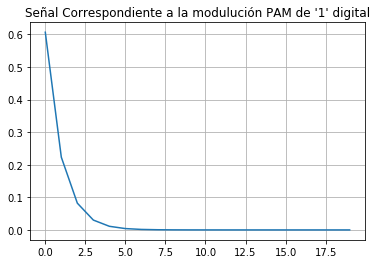

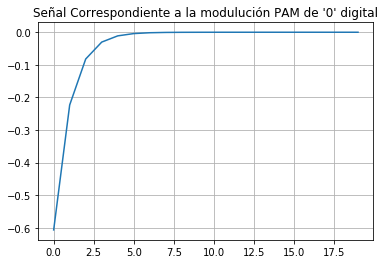

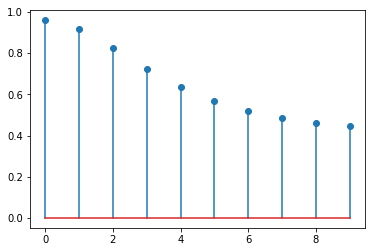

In [89]:
#Abrimos el archivo correspondiente al pulso y lo terminamos graficando
pulse = np.load('pulse.npy')
plt.figure(1)
plt.plot(pulse)
plt.title("Señal Correspondiente a la modulución PAM de '1' digital")
plt.grid()

plt.figure(2)
plt.plot(-1*pulse)
plt.title("Señal Correspondiente a la modulución PAM de '0' digital")
plt.grid()


#Dibujamos la FFT, adaptado de la funcion de PSF con frecuencia de muestreo igual a 1
pulse_fft_db = 20*np.log10(np.abs(sc.fft(pulse )))
pulse_fft    = np.abs(sc.fft(pulse ))
half_fft     = pulse_fft[0:len(pulse_fft)//2]
plt.figure(3)
plt.stem(half_fft)


<div class="alert alert-block alert-info">
<b>2)</b> El espectro de la señal ocupa todo el posible espectro en todas las frecuencia. Por ende cualquier filtro digital que hagamos va sacarnos un porcentaje de la señal util. 
</div>
<div class="alert alert-block alert-info">
<b>3)</b> La idea a paretir de ahora es generar una secuencia del header del bitstream recibido para ver como queda a la salida de los filtros digitales propuestos y ver si podemos seguir reconociendo la informacion.
</div>


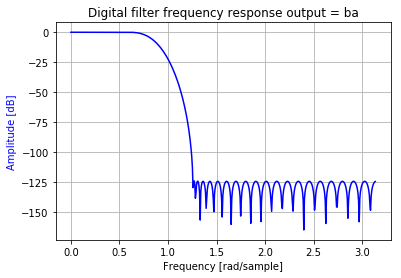

In [90]:
#Load low pass FIR este filtro fue generado por la herramienta pyfda
#Cargamos el filtro digital para ver su transferencia.
#Podemos sacarle mucho ruido de esta manera
files = np.load('low_pass_filter_2.npz')
coefficient=files['ba.npy']
b = coefficient[0].flatten()
a = coefficient[1].flatten()

w, h = signal.freqz(b,a)

fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response output = ba')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')
ax1.grid()

/home/glavigna/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


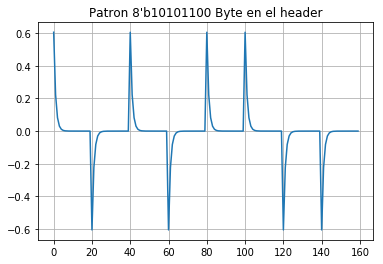

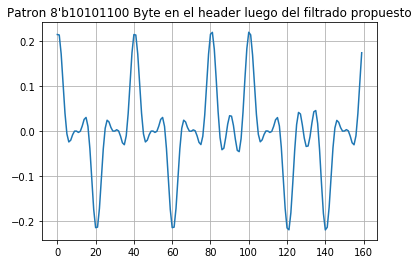

In [91]:
#Generamos a modo de ejemplo una secuencia correspondiente al header de la señal

bit_samples  = 20
bit_in_bytes = 8
bytes_in_header = 16

first_slice  = bit_samples*bit_in_bytes
second_slice = 2*bit_samples*bit_in_bytes

header_bit_stream = np.concatenate((pulse, -pulse, pulse,-pulse,pulse,pulse,-pulse,-pulse), axis=0)
header_bit_stream = np.tile(header_bit_stream,bytes_in_header)
plt.figure(4)
plt.plot(header_bit_stream[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header")
plt.grid()

#Aplicamos la tecnica que genera dos veces el filtrado de esta manera eliminada el retardo de grupo.
header_bit_stream_lp = signal.filtfilt(b,a,header_bit_stream)
plt.figure(5)
plt.plot(header_bit_stream_lp[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header luego del filtrado propuesto")
plt.grid()


In [92]:
#Lo que hacemos es ver en un offset si mayor o menor que cero un valor.
def threshold_level_decision(vector,offset):
    if(vector[offset] > 0):
        return 1
    else :
        return 0
    
#Lo analizamos teniendo en cuenta cuantas derivada negativas hay y cuantas positivas
def threshold_edge_decision(vector,offset_low,offset_high):
    low_edge  = 0
    high_edge = 0
    
    for i in range(offset_high - offset_low):
        if(vector[i+offset_low+1]  > vector[i+offset_low]):
            high_edge += (vector[i+offset_low+1]-vector[i+offset_low])
        else :
            low_edge  += (vector[i+offset_low] - vector[i+offset_low+1])
    
    #Significa que tenemos una señal que tiene pendiente positiva en su mayor
    if(high_edge > low_edge):
        return 0
    else:
        return 1
        

#Generamos el arreglo de unos y ceros a partir de una señal de entrada
offset     = 1
low_slice  = 0
high_slice = 0 

bit_array = np.array([])
bit_array_edge = np.array([])

for i in range((bit_in_bytes*bytes_in_header)):
    low_slice = i*20;
    high_slice = (i+1)*20
    vector_slice = header_bit_stream_lp[low_slice : high_slice]    
    bit_array=np.append(bit_array,threshold_level_decision(vector_slice,offset))

#Imprimimos el header decodificado con alta relacion señal ruido.

def print_header(bit_array):
    low_slice  = 0    
    high_slice = 8  
    byte_index = 0
    for i in range(np.size(bit_array)//8):
        print("Header BYTE {}:{}".format(i,bit_array[low_slice:high_slice]))
        low_slice  += 8
        high_slice += 8
        byte_index += 1

print_header(bit_array)
    

Header BYTE 0:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 1:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 2:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 3:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 4:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 5:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 6:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 7:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 8:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 9:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 10:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 11:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 12:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 13:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 14:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 15:[1. 0. 1. 0. 1. 1. 0. 0.]


<div class="alert alert-block alert-info">
<b>4)</b> Analizamos la señal con menor cantidad de ruido.Utilizando un filtro FIR.
</div>

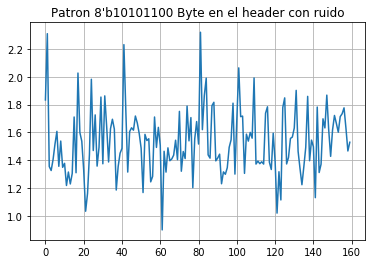

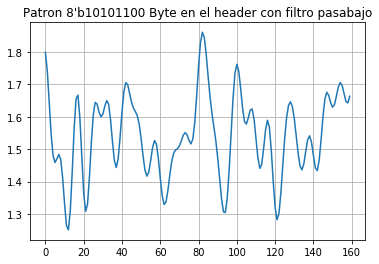

In [93]:
signal_low_noise           = np.load('signalLowSNR.npy')
signal_low_noise_filtered  = signal.filtfilt(b,a,signal_low_noise)

first_slice  = 1*bit_samples*bit_in_bytes
second_slice = 2*bit_samples*bit_in_bytes

plt.figure(6)
plt.plot(signal_low_noise[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header con ruido")
plt.grid()

plt.figure(7)
plt.plot(signal_low_noise_filtered[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header con filtro pasabajo")
plt.grid()


#Generamos el arreglo de unos y ceros a partir de una señal de entrada
offset      = 1
low_slice   = 0
high_slice  = 0 

bit_array_low_noise      = np.array([])
bit_array_low_noise_edge = np.array([])

for i in range((bit_in_bytes*bytes_in_header)):
    low_slice  = i*20;
    high_slice = (i+1)*20
    #Le restamos la media para sacar la continua en lo que respecta a esta slice
    vector_slice = signal_low_noise_filtered[low_slice : high_slice] - np.mean(signal_low_noise_filtered[low_slice : high_slice])
    bit_array_low_noise      = np.append(bit_array_low_noise,threshold_level_decision(vector_slice,offset))


In [94]:
def number_of_incorrect_bits(pattern_bits,decoded_bits):
    return np.sum(np.abs(pattern_bits - decoded_bits))

print("Cantidad de bits incorrectos metodo muestreo unico:{}".format(number_of_incorrect_bits(bit_array,bit_array_low_noise)))   
    

Cantidad de bits incorrectos metodo muestreo unico:2.0


In [95]:
#Imprimimos el header decodificado con alta relacion señal ruido.

def print_header(bit_array):
    low_slice  = 0    
    high_slice = 8  
    byte_index = 0
    for i in range(np.size(bit_array)//8):
        print("Header BYTE {}:{}".format(i,bit_array[low_slice:high_slice]))
        low_slice  += 8
        high_slice += 8
        byte_index += 1

print_header(bit_array_low_noise)

Header BYTE 0:[0. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 1:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 2:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 3:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 4:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 5:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 6:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 7:[1. 0. 1. 1. 1. 1. 0. 0.]
Header BYTE 8:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 9:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 10:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 11:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 12:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 13:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 14:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 15:[1. 0. 1. 0. 1. 1. 0. 0.]


<div class="alert alert-block alert-info">
<b>5)</b> Analizamos la señal con mayor cantidad de ruido. Utilizando un filtro FIR.
</div>

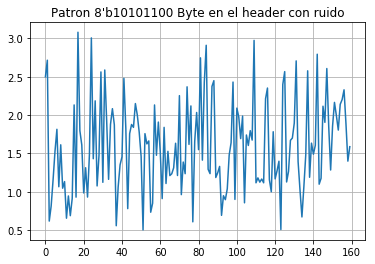

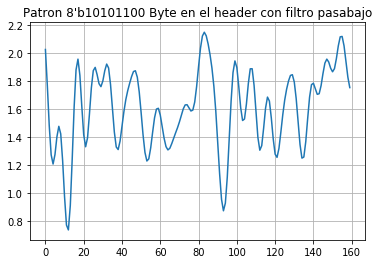

In [96]:
signal_noise           = np.load('signal.npy')
signal_noise_filtered  = signal.filtfilt(b,a,signal_noise)

first_slice  = 1*bit_samples*bit_in_bytes
second_slice = 2*bit_samples*bit_in_bytes

plt.figure(6)
plt.plot(signal_noise[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header con ruido")
plt.grid()

plt.figure(7)
plt.plot(signal_noise_filtered[first_slice:second_slice])
plt.title("Patron 8'b10101100 Byte en el header con filtro pasabajo")
plt.grid()


#Generamos el arreglo de unos y ceros a partir de una señal de entrada
offset      = 1
low_slice   = 0
high_slice  = 0 

bit_array_noise      = np.array([])
bit_array_noise_edge = np.array([])

for i in range((bit_in_bytes*bytes_in_header)):
    low_slice  = i*20;
    high_slice = (i+1)*20
    #Le restamos la media para sacar la continua en lo que respecta a esta slice
    vector_slice    = signal_noise_filtered[low_slice : high_slice] - np.mean(signal_noise_filtered[low_slice : high_slice])
    bit_array_noise = np.append(bit_array_noise,threshold_level_decision(vector_slice,offset))    


In [97]:
def number_of_incorrect_bits(pattern_bits,decoded_bits):
    return np.sum(np.abs(pattern_bits - decoded_bits))

print("Cantidad de bits incorrectos metodo muestreo unico:{}".format(number_of_incorrect_bits(bit_array,bit_array_noise)))
    

Cantidad de bits incorrectos metodo muestreo unico:30.0


In [98]:
#Imprimimos el header decodificado con alta relacion señal ruido.

def print_header(bit_array):
    low_slice  = 0    
    high_slice = 8  
    byte_index = 0
    for i in range(np.size(bit_array_noise)//8):
        print("Header BYTE {}:{}".format(i,bit_array[low_slice:high_slice]))
        low_slice  += 8
        high_slice += 8
        byte_index += 1

print_header(bit_array_noise)
    

Header BYTE 0:[0. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 1:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 2:[1. 1. 1. 1. 1. 1. 0. 0.]
Header BYTE 3:[1. 0. 0. 1. 1. 1. 0. 1.]
Header BYTE 4:[1. 1. 1. 1. 1. 1. 1. 0.]
Header BYTE 5:[1. 0. 1. 1. 1. 0. 1. 1.]
Header BYTE 6:[0. 0. 1. 0. 0. 1. 1. 1.]
Header BYTE 7:[1. 0. 1. 1. 0. 1. 0. 0.]
Header BYTE 8:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 9:[0. 0. 1. 1. 1. 1. 0. 0.]
Header BYTE 10:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 11:[1. 0. 1. 0. 1. 1. 0. 1.]
Header BYTE 12:[1. 0. 0. 0. 1. 1. 0. 1.]
Header BYTE 13:[1. 0. 1. 0. 1. 1. 1. 0.]
Header BYTE 14:[0. 1. 1. 0. 1. 1. 0. 0.]
Header BYTE 15:[1. 0. 1. 0. 0. 1. 1. 1.]


<div class="alert alert-block alert-info">
<b>6)</b> Realizamos el filtro adaptado para la señal de bajo ruido.
</div>

THRESHOLD --> Minimo de la resta de las CDF=1.4170854271356783
Algunos THRESHOLD que pueden ser coherentes
Punto medio entre las medias de las pdf calculadas=1.3988471256384023
Media de las señal Filtrada=1.380716474352364
Cantidad de bits incorrectos metodo muestreo unico:0.0


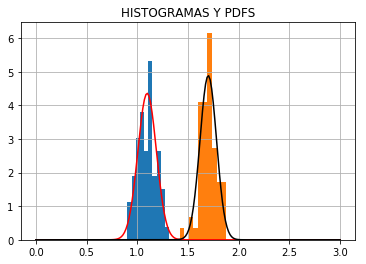

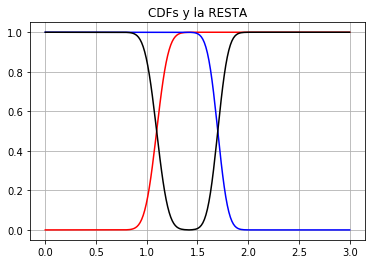

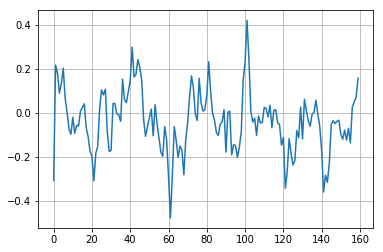

In [107]:
#Abrimos el archivo correspondiente al pulso
pulse = np.load('pulse.npy')
#Abrimos la señal con baja cantidad de ruido
signal_noise = np.load('signalLowSNR.npy')
#Generamos el patron para el header
bit_array = np.array([1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0])

bit_samples     = 20
bit_in_bytes    = 8
bytes_in_header = 16

#Realizamos un filtro digital, con el flipeado de la señal de referencia que se usa para la modulacion.
#Es equivalente a la convolucion. El filt filt nos deja con fase 0 y sin muestras
signal_matched_filter_high = signal.filtfilt(np.flip(pulse),1,signal_noise)

#Hacemos el subsampling del header, a partir de la muestra numero 1.
offset = 1
sub_sampling=signal_matched_filter_high[offset:(128*20):20]

#Obtenemos las metricas y estimamos una funcion de probabilidad en base a los datos conocidos.
#Decidimos realizar el modelo utilizando una funcion de distribucion normal.

#Obtenemos los valores de los valores que deberian valer 1 y los que deberian valer 0.
sub_sampling_ones  = sub_sampling[bit_array == 1]
sub_sampling_zeros = sub_sampling[bit_array == 0]

#Media y Desvio estandar cuando sabemos que un valor debe de tener P(X/1)
mean_ones   = np.mean(sub_sampling_ones) 
std_ones    = np.std(sub_sampling_ones) 

#Media y Desvio estandar cuando sabemos que un valor debe de tener P(X/0)
mean_zeros  = np.mean(sub_sampling_zeros)
std_zeros   = np.std(sub_sampling_zeros)

#Estas son funciones que sirven para tener lasw funciones de probabilidades y obtener las pdf y las cdf
normal_ones=scipy.stats.norm(mean_ones, std_ones)
normal_zeros=scipy.stats.norm(mean_zeros, std_zeros)


#Obtenemos los datos necesarios para realizar el ploteo de las distribuciones obtenidas.
x = np.linspace(0,3,200)
y_ones_pdf  = normal_ones.pdf(x)
y_zeros_pdf = normal_zeros.pdf(x)
y_ones_cdf  = normal_ones.cdf(x)
y_zeros_cdf = normal_zeros.cdf(x)


#Dibujamos los histogramas y las pdf estimadas.
plt.hist(sub_sampling_zeros, bins = 10,normed=1, cumulative=False)
plt.plot(x,y_zeros_pdf,'r')

#Dibujamos los histogramas y las pdf estimadas.
plt.hist(sub_sampling_ones, bins = 10,normed=1, cumulative=False)
plt.plot(x,y_ones_pdf,'k')
plt.title('HISTOGRAMAS Y PDFS')
plt.grid(True)

#Claramente obtenemos un buen threshold
#Para encontrar los threshold obtenemos las cdefs correspondientes.

plt.figure()
plt.plot(x,y_zeros_cdf,'r')
plt.plot(x,1-y_ones_cdf ,'b')
plt.plot(x,np.abs((1-y_ones_cdf)-y_zeros_cdf),'k')
plt.title('CDFs y la RESTA')
plt.grid(True)

#En el minimo de la resta esta el threshold optimo
threshold = np.where(np.abs((1-y_ones_cdf)-y_zeros_cdf) == np.amin(np.abs((1-y_ones_cdf)-y_zeros_cdf)))
threshold = x[threshold[0][0]]

print('THRESHOLD --> Minimo de la resta de las CDF={}'.format(threshold))

print('Algunos THRESHOLD que pueden ser coherentes')
print('Punto medio entre las medias de las pdf calculadas={}'.format(0.5*(mean_ones+mean_zeros)))
print('Media de las señal Filtrada={}'.format(np.mean(signal_matched_filter_high)))

#Con este minimo en mente realizamos la resta
signal_matched_filter_high -= threshold

#Generamos el arreglo comparando con cero, ya que le restamos el threshold
bit_array_matched_filter_ln = np.array([])

#Esto es herencia pero se puede hacer directamente con el submuestreo.
for i in range((bit_in_bytes*bytes_in_header)):
    low_slice = i*20;
    high_slice = (i+1)*20
    vector_slice = signal_matched_filter_high[low_slice : high_slice] 
    bit_array_matched_filter_ln=np.append(bit_array_matched_filter_ln,threshold_level_decision(vector_slice,offset))

print("Cantidad de bits incorrectos metodo muestreo unico:{}".format(number_of_incorrect_bits(bit_array,bit_array_matched_filter_ln)))   

#Hacemos unos plot de los primero 8 pulsos
plt.figure()
plt.plot(signal_matched_filter_high[0:160])
plt.grid('True')



In [106]:
#Imprimimos el header decodificado con baja relacion señal ruido.

def print_header(bit_array):
    low_slice  = 0    
    high_slice = 8  
    byte_index = 0
    for i in range(np.size(bit_array_noise)//8):
        print("Header BYTE {}:{}".format(i,bit_array[low_slice:high_slice]))
        low_slice  += 8
        high_slice += 8
        byte_index += 1

print_header(bit_array_matched_filter_ln)

Header BYTE 0:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 1:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 2:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 3:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 4:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 5:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 6:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 7:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 8:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 9:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 10:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 11:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 12:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 13:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 14:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 15:[1. 0. 1. 0. 1. 1. 0. 0.]


<div class="alert alert-block alert-info">
<b>7)</b> Realizamos el filtro adaptado para la señal de alto ruido.
</div>

THRESHOLD --> Minimo de la resta de las CDF=1.4472361809045227
Algunos THRESHOLD que pueden ser coherentes
Punto medio entre las medias de las pdf calculadas=1.4351516992491269
Media de las señal Filtrada=1.380468823635013
Cantidad de bits incorrectos metodo muestreo unico:15.0


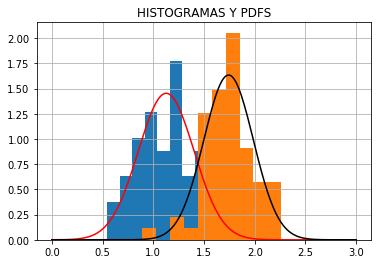

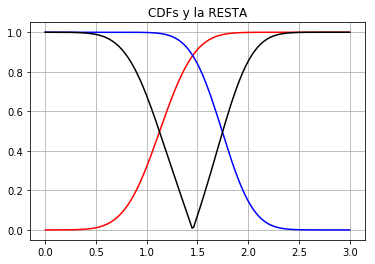

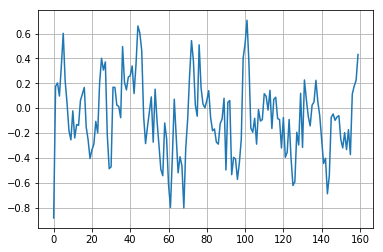

In [105]:
#Abrimos el archivo correspondiente al pulso
pulse = np.load('pulse.npy')
#Abrimos la señal con alta cantidad de ruido
signal_noise = np.load('signal.npy')
#Generamos el patron para el header
bit_array = np.array([1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0])

bit_samples     = 20
bit_in_bytes    = 8
bytes_in_header = 16

#Realizamos un filtro digital, con el flipeado de la señal de referencia que se usa para la modulacion.
#Es equivalente a la convolucion. El filt filt nos deja con fase 0 y sin muestras
signal_matched_filter_high = signal.filtfilt(np.flip(pulse),1,signal_noise)


#Hacemos el subsampling del header, a partir de la muestra numero 1.
offset = 1
sub_sampling=signal_matched_filter_high[offset:(128*20):20]

#Obtenemos las metricas y estimamos una funcion de probabilidad en base a los datos conocidos.
#Decidimos realizar el modelo utilizando una funcion de distribucion normal.

#Obtenemos los valores de los valores que deberian valer 1 y los que deberian valer 0.
sub_sampling_ones  = sub_sampling[bit_array == 1]
sub_sampling_zeros = sub_sampling[bit_array == 0]

#Media y Desvio estandar cuando sabemos que un valor debe de tener P(X/1)
mean_ones   = np.mean(sub_sampling_ones) 
std_ones    = np.std(sub_sampling_ones) 

#Media y Desvio estandar cuando sabemos que un valor debe de tener P(X/0)
mean_zeros  = np.mean(sub_sampling_zeros)
std_zeros   = np.std(sub_sampling_zeros)

#Estas son funciones que sirven para tener lasw funciones de probabilidades y obtener las pdf y las cdf
normal_ones=scipy.stats.norm(mean_ones, std_ones)
normal_zeros=scipy.stats.norm(mean_zeros, std_zeros)


#Obtenemos los datos necesarios para realizar el ploteo de las distribuciones obtenidas.
x = np.linspace(0,3,200)
y_ones_pdf  = normal_ones.pdf(x)
y_zeros_pdf = normal_zeros.pdf(x)
y_ones_cdf  = normal_ones.cdf(x)
y_zeros_cdf = normal_zeros.cdf(x)


#Dibujamos los histogramas y las pdf estimadas.
plt.hist(sub_sampling_zeros, bins = 10,normed=1, cumulative=False)
plt.plot(x,y_zeros_pdf,'r')

#Dibujamos los histogramas y las pdf estimadas.
plt.hist(sub_sampling_ones, bins = 10,normed=1, cumulative=False)
plt.plot(x,y_ones_pdf,'k')
plt.title('HISTOGRAMAS Y PDFS')
plt.grid(True)

#Para encontrar los threshold obtenemos las cdfs correspondientes.
#Al tener mucho mas ruido obtenemos que la estimacion de las probabilidades se terminan tocando
#mucho mas que en el caso de bajo ruido.

plt.figure()
plt.plot(x,y_zeros_cdf,'r')
plt.plot(x,1-y_ones_cdf ,'b')
plt.plot(x,np.abs((1-y_ones_cdf)-y_zeros_cdf),'k')
plt.title('CDFs y la RESTA')
plt.grid(True)



#En el minimo de la resta esta el threshold optimo
threshold = np.where(np.abs((1-y_ones_cdf)-y_zeros_cdf) == np.amin(np.abs((1-y_ones_cdf)-y_zeros_cdf)))
threshold = x[threshold[0][0]]

print('THRESHOLD --> Minimo de la resta de las CDF={}'.format(threshold))

print('Algunos THRESHOLD que pueden ser coherentes')
print('Punto medio entre las medias de las pdf calculadas={}'.format(0.5*(mean_ones+mean_zeros)))
print('Media de las señal Filtrada={}'.format(np.mean(signal_matched_filter_high)))


#Con este minimo en mente realizamos la resta
signal_matched_filter_high -= threshold

#Descomentar si se quiere probar otro thresholds
#signal_matched_filter_high -= 0.5*(mean_ones+mean_zeros)
#signal_matched_filter_high -= np.mean(signal_matched_filter_high)


#Generamos el arreglo comparando con cero, ya que le restamos el threshold
bit_array_matched_filter_hn = np.array([])

#Esto es herencia pero se puede hacer directamente con el submuestreo.
for i in range((bit_in_bytes*bytes_in_header)):
    low_slice = i*20;
    high_slice = (i+1)*20
    vector_slice = signal_matched_filter_high[low_slice : high_slice] 
    bit_array_matched_filter_hn=np.append(bit_array_matched_filter_hn,threshold_level_decision(vector_slice,offset))

print("Cantidad de bits incorrectos metodo muestreo unico:{}".format(number_of_incorrect_bits(bit_array,bit_array_matched_filter_hn)))   

#Hacemos unos plot de los primero 8 pulsos
plt.figure()
plt.plot(signal_matched_filter_high[0:160])
plt.grid('True')


In [102]:
#Imprimimos el header decodificado con baja relacion señal ruido.

def print_header(bit_array):
    low_slice  = 0    
    high_slice = 8  
    byte_index = 0
    for i in range(np.size(bit_array_noise)//8):
        print("Header BYTE {}:{}".format(i,bit_array[low_slice:high_slice]))
        low_slice  += 8
        high_slice += 8
        byte_index += 1

print_header(bit_array_matched_filter_hn)

Header BYTE 0:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 1:[1. 0. 1. 0. 1. 1. 0. 1.]
Header BYTE 2:[1. 0. 1. 0. 1. 1. 0. 1.]
Header BYTE 3:[1. 0. 1. 1. 1. 1. 0. 1.]
Header BYTE 4:[1. 1. 1. 0. 1. 1. 0. 0.]
Header BYTE 5:[1. 0. 1. 1. 1. 1. 1. 1.]
Header BYTE 6:[0. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 7:[1. 0. 1. 1. 0. 1. 0. 0.]
Header BYTE 8:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 9:[0. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 10:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 11:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 12:[1. 0. 1. 0. 1. 1. 1. 0.]
Header BYTE 13:[1. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 14:[0. 0. 1. 0. 1. 1. 0. 0.]
Header BYTE 15:[1. 0. 1. 0. 1. 1. 0. 1.]


In [104]:
#Resumen de resultados
#Filtros digitales
number_of_bits                  = 128
err_low_noise_digital_filter    = 2
err_high_noise_digital_filter   = 30
err_low_noise_matched_filter    = 0
err_high_noise_matched_filter   = 15

print("Filtro Digital:Aciertos %-->LOW NOISE:{} HIGH NOISE:{}".format(1-err_low_noise_digital_filter/128,1-err_high_noise_digital_filter/128))
print("Filtro Matched:Aciertos %-->LOW NOISE:{} HIGH NOISE:{}".format(1-err_low_noise_matched_filter/128,1-err_high_noise_matched_filter/128))


Filtro Digital:Aciertos %-->LOW NOISE:0.984375 HIGH NOISE:0.765625
Filtro Matched:Aciertos %-->LOW NOISE:1.0 HIGH NOISE:0.8828125


<div class="alert alert-block alert-info">
<b>8)</b> En resumen para el filtro adaptado para el header con el matched filter bajamos a la mitad los errores
</div>